In [1]:
# check Colab environment
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6806348058958446692
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7848949683492307456
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Setup

In [2]:
!pip install datasets
!pip install transformers
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.1 MB/s 
     |████████████████████████████████| 132 kB 68.9 MB/s 
     |████████████████████████████████| 212 kB 69.7 MB/s 
     |████████████████████████████████| 182 kB 72.5 MB/s 
     |████████████████████████████████| 127 kB 61.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 60.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.0 MB/s 


In [52]:
import os
import re
import nltk
import torch
import evaluate
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.optim import AdamW
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import get_scheduler
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoModelForSequenceClassification

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Download datasets from Kaggle

In [4]:
# directory containing Kaggle API token
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/.kaggle/'

In [5]:
!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format

 19% 5.00M/25.7M [00:00<00:00, 35.6MB/s]
100% 25.7M/25.7M [00:00<00:00, 131MB/s] 


In [6]:
!ls

drive  imdb-dataset-sentiment-analysis-in-csv-format.zip  sample_data


In [7]:
# unzip then delete zip files
!unzip \*.zip  && rm *.zip

Archive:  imdb-dataset-sentiment-analysis-in-csv-format.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: Valid.csv               


# EDA

In [32]:
df_train = pd.read_csv('Train.csv')
df_val = pd.read_csv('Valid.csv')
df_test = pd.read_csv('Test.csv')

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(40000, 2)
(5000, 2)
(5000, 2)


In [ ]:
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
# check class distribution
df_train['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [ ]:
# check for missing values
df_train.isnull().sum()

text     0
label    0
dtype: int64

# Data Preprocessing

We want to clean our dataset by:
- removing numbers and punctuation
- removing stop words
  - as we're not using the full text for a task like language translation, we can remove words like "a", "the", "of" etc.
- lemmatizing remaining words
  - converting words into their common base form

In [33]:
stop_words = set(nltk.corpus.stopwords.words('english'))
wnl = WordNetLemmatizer()

In [34]:
def preprocess(text):
  # remove anything non-alphabetic or whitespace characters and convert to lower case
  text = re.sub('[^a-z\s]', '', text.lower())
  # remove stopwords and lemmatize remaining words
  text = [wnl.lemmatize(word) for word in text.split(' ') if word not in stop_words]
  
  return ' '.join(text)

In [35]:
df_train['text_clean'] = df_train['text'].apply(preprocess)
df_val['text_clean'] = df_val['text'].apply(preprocess)
df_test['text_clean'] = df_test['text'].apply(preprocess)

In [36]:
df_train.head()

,text,label,text_clean
0,I grew up (b. 1965) watching and loving the Th...,0,grew b watching loving thunderbird mate schoo...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chip expectation...
2,Why do people who do not know what a particula...,0,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dad army fan nothing ever change g...


In [37]:
# vectorize text so that it can be interpreted by model

cv = CountVectorizer(binary=True)
cv.fit(df_train['text_clean'])

X_train = cv.transform(df_train['text_clean'])
X_val = cv.transform(df_val['text_clean'])
X_test = cv.transform(df_test['text_clean'])

y_train = df_train['label'].values
y_val = df_val['label'].values
y_test = df_test['label'].values

# Train Models

### XGBoost

In [38]:
# create datasets for XGBoost

d_train = xgb.DMatrix(X_train, y_train)
d_val = xgb.DMatrix(X_val, y_val)
d_test = xgb.DMatrix(X_test, y_test)

In [39]:
# define function to parse XGBoost output

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_mae', 'val_mae']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [49]:
%%capture output

xgb_parameters  = {
    'eta': 0.5,
    'max_depth': 6,
    'min_child_weight': 20,

    'objective': 'binary:logistic',
    'eval_metric': 'mae',
    
    'nthread': 8,
    'seed': 0,
    'verbosity': 1,
}

watch_list = [(d_train, 'train'), (d_val, 'val')]

xgb_model = xgb.train(
    xgb_parameters,
    d_train,
    num_boost_round=200,
    evals=watch_list
)

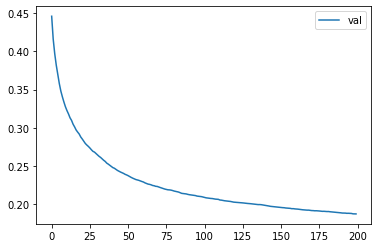

In [51]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [53]:
y_pred = xgb_model.predict(d_val)
mean_absolute_error(y_val, y_pred)

0.18763299089591168

### XGBoost Hyperparameter Tuning

##### Eta

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_parameters = {
    'eta': 1, # try 0.01, 0.05, 0.1, 0.5, 1
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(
    xgb_parameters,
    d_train, 
    num_boost_round=100,
    verbose_eval=5,
    evals=watch_list
)

In [ ]:
key = 'eta=%s' % (xgb_parameters['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1'

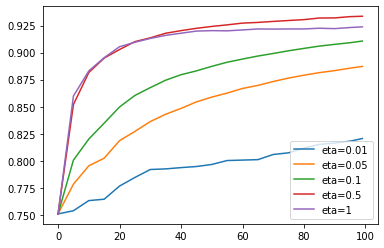

In [ ]:
etas = [
    'eta=0.01',
    'eta=0.05',
    'eta=0.1',
    'eta=0.5', # best
    'eta=1'
]

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

##### Max Depth

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_parameters = {
    'eta': 0.5, # best eta from previous experiment
    'max_depth': 6, # try 1,2,3,4,5,6
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(
    xgb_parameters,
    d_train, 
    num_boost_round=100,
    verbose_eval=5,
    evals=watch_list
)

In [ ]:
key = 'max_depth=%s' % (xgb_parameters['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

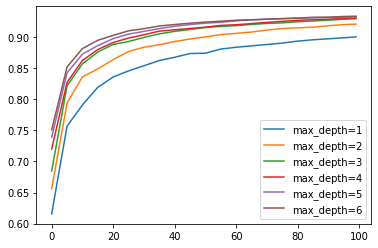

In [ ]:
max_depths = [
    'max_depth=1',
    'max_depth=2',
    'max_depth=3',
    'max_depth=4',
    'max_depth=5',
    'max_depth=6' # best
]

for max_depth in max_depths:
    df_score = scores[max_depth]
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

##### Min Child Weight

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_parameters = {
    'eta': 0.5, # best eta from previous experiment
    'max_depth': 6, # best max_depth from previous experiment
    'min_child_weight': 0, # try 0,1,5,10,20
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(
    xgb_parameters,
    d_train, 
    num_boost_round=100,
    verbose_eval=5,
    evals=watch_list
)

In [ ]:
key = 'min_child_weight=%s' % (xgb_parameters['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=0'

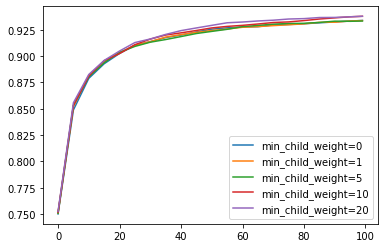

In [ ]:
min_child_weights = [
    'min_child_weight=0',
    'min_child_weight=1',
    'min_child_weight=5',
    'min_child_weight=10',
    'min_child_weight=20', # best
]

for min_child_weight in min_child_weights:
    df_score = scores[min_child_weight]
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.legend()

### Transformer

In [8]:
# load datasets for Transformer

data_files = {
    'train': 'Train.csv',
    'val': 'Valid.csv',
    'test': 'Test.csv',
}

datasets = load_dataset('./', data_files=data_files)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/.-72a7fd6ecd80a5fe/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
# tokenize review text

def tokenization(review):
  return tokenizer(review['text'], padding='max_length', truncation=True)


tokenized_datasets = datasets.map(tokenization, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets.set_format('torch')

In [61]:
# create smaller datasets for faster training

small_train_dataset = tokenized_datasets['train'].shuffle(seed=42).select(range(1000))
small_val_dataset = tokenized_datasets['val'].shuffle(seed=42).select(range(1000))
small_test_dataset = tokenized_datasets['test'].shuffle(seed=42).select(range(1000))

In [62]:
# create DataLoaders to iterate over datasets in batches

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
val_dataloader = DataLoader(small_val_dataset, batch_size=8)
test_dataloader = DataLoader(small_test_dataset, batch_size=8)

In [19]:
# load Transformer model for binary classification (our reviews are either positive or negative)

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
# use AdamW optimizer

optimizer = AdamW(model.parameters(), lr=5e-5)

In [57]:
# use a linear learning rate scheduler to decay the learning rate

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name='linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [22]:
# specify backend for traning (will use GPU when running in Google Colab)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [42]:
# train model

progress_bar = tqdm(range(num_training_steps))

model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/375 [00:00<?, ?it/s]

In [48]:
# evaluate on validation set

metric = evaluate.load('mae')

model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch['labels'])

metric.compute()

{'mae': 0.112}

# Select Best Model

In [58]:
# XGBoost

y_pred = xgb_model.predict(d_test)
mean_absolute_error(y_test, y_pred)

0.19115223524533242

In [63]:
# Transformer - winner

model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch['labels'])

metric.compute()

{'mae': 0.112}

- XGBoost MAE: 0.191
- Transformer MAE: 0.112